Reading in data

In [54]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import data_generation
import numpy as np
import datetime


darts_data_file = "darts_data.csv"
if os.path.exists(darts_data_file):
    df = pd.read_csv(darts_data_file, index_col="date", parse_dates=True)
    df.drop(["Unnamed: 0"], axis=1, inplace=True)
else:
    darts_log = data_generation.TrainingBook()
    darts_log.fill()

    df = pd.DataFrame(darts_log.entries)
    df.to_csv("darts_data.csv")
    print("darts_data.csv was created...")

df.head()
# df.describe()


,round_nr,throw_nr,dart_nr,prefix,score,value
date,,,,,,
2021-05-10,1,1,1,S,1,1
2021-05-10,1,1,2,D,5,10
2021-05-10,1,1,3,S,20,20
2021-05-10,1,2,1,S,12,12
2021-05-10,1,2,2,S,20,20


Nr of trainings and monthly averages

In [ ]:
def monthly_trainings(data):
    '''Nr of trainings per month'''
    grouplist = [df.index.year, df.index.month]
    return df[["round_nr"]].groupby(grouplist).count()/33/3


def monthly_averages(data):
    '''3-dart averages per month'''
    grouplist = [data.index.year, data.index.month]
    monthly_throw = data.groupby(grouplist)[['value']].count()
    return data.groupby(grouplist)[['value']].sum()/monthly_throw*3


# Creating the plots
fig, axs = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle("Monthly statistics", fontsize=20, fontweight="normal")

mt = monthly_trainings(df)
mt.plot(ax=axs[0], kind='bar', color='lightsteelblue', rot=90)

ma = monthly_averages(df)
ma.plot(ax=axs[1], kind='line', color='lightsteelblue', marker='o', rot=90)

# Formatting
axs[0].set(title="Nr of rounds per month", xlabel="Date", ylabel="Nr of rounds")
axs[1].set(title="Monthly Average", xlabel="Date", ylabel="3-Dart Average")
axs[0].yaxis.grid(color='gray', linestyle='dotted')
axs[1].yaxis.grid(color='gray', linestyle='dashed')
axs[1].xaxis.grid(color='gray', linestyle='dashed')

for ax in axs:
    ax.set_axisbelow(True)
    

Nr of trainings and monthly averages with resampling

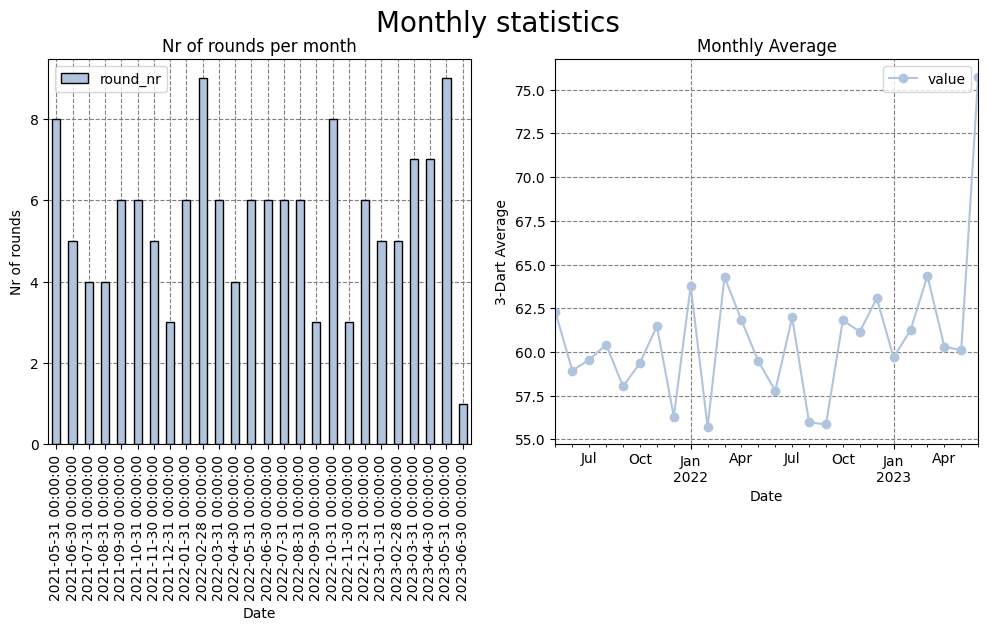

In [25]:
def monthly_trainings_res(data):
    '''Nr of trainings per month with resampling'''
    mtr = data[["round_nr"]].resample("D").max().resample("M").sum()
    return mtr


def monthly_averages_res(data):
    '''3-dart averages per month with resampling'''
    data_res = data[["value"]].resample("M")
    mar = data_res.sum() / data_res.count() * 3
    return mar


#Plotting
fig, axs = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle("Monthly statistics", fontsize=20, fontweight="normal")

monthly_trainings_res(df).plot(ax=axs[0], kind='bar', color='lightsteelblue', edgecolor='black', rot=90)
monthly_averages_res(df).plot(ax=axs[1], kind='line', color='lightsteelblue', marker='o')

# Formatting
axs[0].set(title="Nr of rounds per month", xlabel="Date", ylabel="Nr of rounds")
axs[1].set(title="Monthly Average", xlabel="Date", ylabel="3-Dart Average")
axs[0].yaxis.grid(color='gray', linestyle='dotted')
axs[1].yaxis.grid(color='gray', linestyle='dashed')
axs[1].xaxis.grid(color='gray', linestyle='dashed')

for ax in axs:
    ax.set_axisbelow(True)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    ax.yaxis.grid(color='gray', linestyle='dashed')


Pie Charts of scores and Histogram

<Axes: >

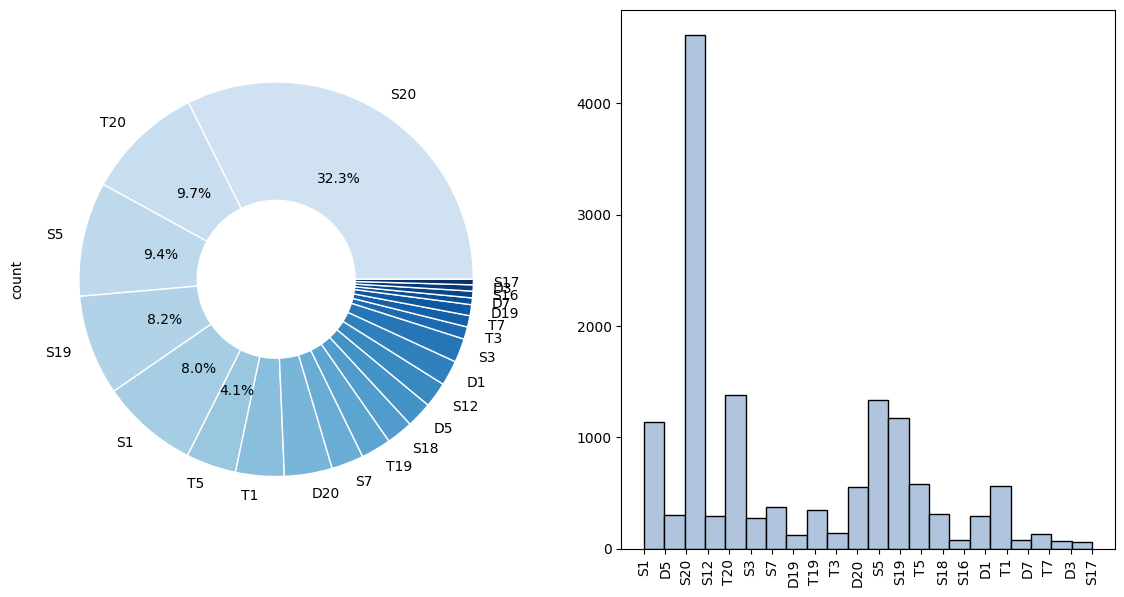

In [26]:
df_field = df.copy()
df_field["field"] = df["prefix"] + df["score"].astype(str)

fig, axs = plt.subplots(1, 2, figsize=(14,7))
colors = plt.get_cmap('Blues')(np.linspace(0.2, 1.0, 22))
df_field["field"].value_counts().plot(ax=axs[0], kind='pie', colors=colors, 
                                      autopct=lambda p: f"{p:.1f}%" if p > 4 else None,
                                      wedgeprops={"linewidth": 1, "edgecolor": "white", "width": 0.6})
df_field["field"].hist(ax=axs[1], color='lightsteelblue', edgecolor='black', grid=False, xrot=90, bins=22)




Monthly Pie Charts of Score in 2022

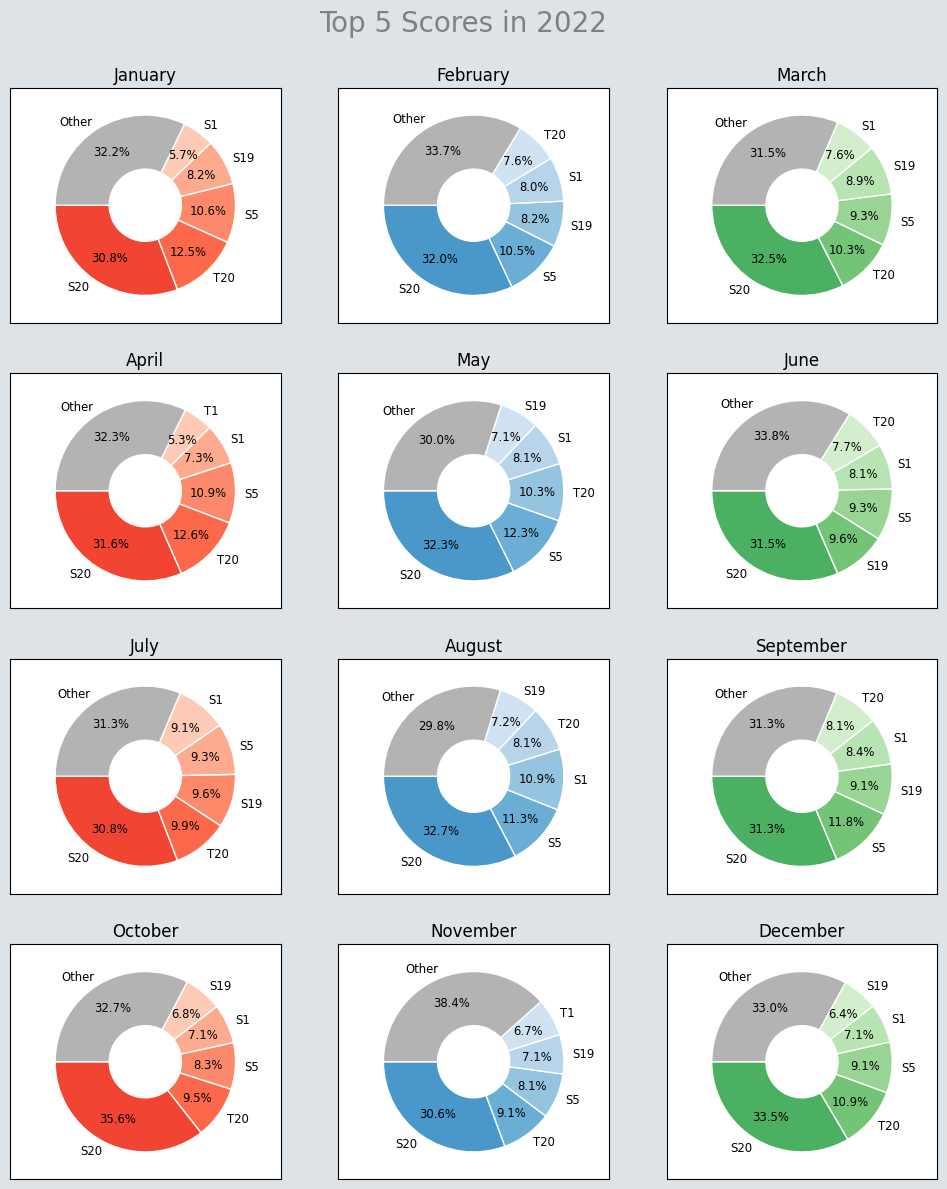

In [27]:
# Setting up dataframe with merged score column (ex: S, 20 -> S20)
df_field = df.copy()
df_field["field"] = df["prefix"] + df["score"].astype(str)

# Creating main plot layout with title
fig, axs = plt.subplots(4, 3, figsize=(10,12), facecolor='#dee3e7')
fig.suptitle("Top 5 Scores in 2022", fontsize=20, color="Gray", y=1.01)
plt.tight_layout()

# Defining constants for plots
TOP_N = 5
colors = [ np.append(plt.get_cmap(color_name)(np.linspace(0.6, 0.2, TOP_N)), [[0.7, 0.7, 0.7, 1]], axis=0) 
          for color_name in ["Reds", "Blues", "Greens"] ]
          
# Looping through months
month_start = pd.to_datetime("2022-01-01")
for i in range(12):

    # Filtering dataframe to the specific month
    month = month_start + pd.DateOffset(months=i)
    df_field_month = df_field[(df_field.index > month) & 
                            (df_field.index < month + pd.DateOffset(months=1))]

    # The top 5 scores 
    pie_top5 = df_field_month["field"].value_counts(sort=True, ascending=False)[:TOP_N]
    
    # Adding all the others as a cummulated pie slice
    count_others = df_field_month["field"].value_counts(sort=True, ascending=False)[TOP_N:].sum()
    pie_top5 = pd.concat([pie_top5, pd.Series(data={"Other":count_others})])

    # Creating and formatting the pie plot    
    row, col = i // 3, i % 3
    axs[row, col].pie(pie_top5,
        labels=pie_top5.index,
        colors=colors[i % 3],
        autopct='%1.1f%%',
        pctdistance=0.7,
        startangle=180,
        counterclock=True,
        wedgeprops={"linewidth": 1, "edgecolor": "white", "width": 0.6},
        textprops={'size': 'smaller'},
        frame=True
        )
    
    # Removing ticks and labels to have frame only
    axs[row, col].set_xlim(-1.5, 1.5)
    axs[row, col].set_xticklabels([])
    axs[row, col].set_xticks([])
    axs[row, col].set_ylim(-1.3, 1.3)
    axs[row, col].set_yticklabels([])
    axs[row, col].set_yticks([])

    # ADding title
    axs[row, col].set_title(month.month_name())



Yearly statistics for score ranges

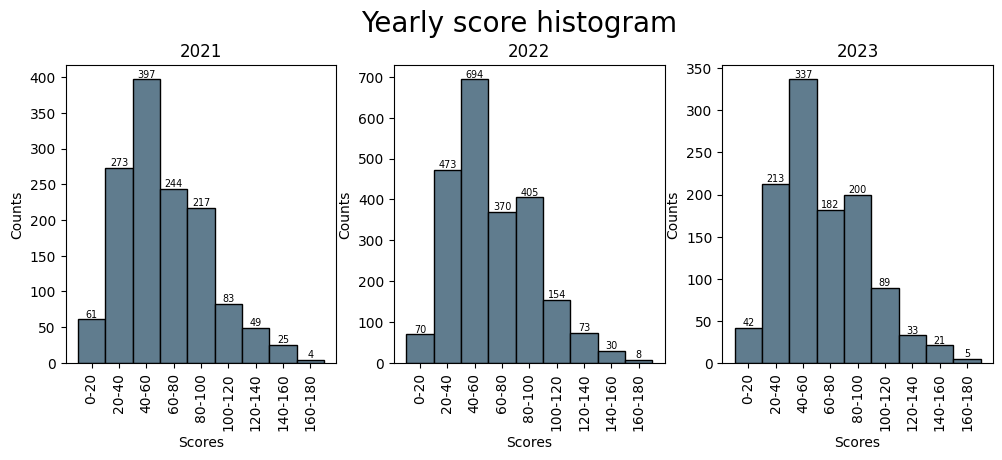

In [127]:
# Setting up dataframe
cols = ["round_nr","throw_nr", "value"]
df_value = df[cols].groupby([df.index, "round_nr", "throw_nr"]).sum()

# Creating main plot layout with title
fig, axs = plt.subplots(1, 3, figsize=(10,4))
fig.suptitle("Yearly score histogram", fontsize=20)
plt.tight_layout()

# Plotting loop
year_filter = pd.to_datetime("2021-01-01")
cols = ["round_nr","throw_nr", "value"]
plot_col = 0
while year_filter.year <= datetime.datetime.now().year:

    # Filtering dataframe to the specific year
    df_year = df[(df.index >= year_filter) & 
                            (df.index < year_filter + pd.DateOffset(years=1))]
    df_year_value = df_year[cols].groupby([df_year.index, "round_nr", "throw_nr"]).sum()
    # df_year_value.to_csv(f"df_year_value_{year_filter.year}")
    
    # Creating hist plot
    hist_plot = df_year_value.plot.hist(
        
        bins=9, 
        range=(0,180),
        legend=False,
        xlabel="Scores",
        ylabel="Counts",
        rot=90,
        title=year_filter.year,
        color="#607c8e", 
        edgecolor="black",
        ax=axs[plot_col]
        )
    
    #Formatting plots
    axs[plot_col].set_xticks(range(10,190,20))
    axs[plot_col].set_xticklabels([f"{i}-{i+20}" for i in range (0, 180, 20)])
    axs[plot_col].bar_label
 
    for c in hist_plot.containers:
        hist_plot.bar_label(c, fontsize="x-small")

    plot_col += 1
    year_filter += pd.DateOffset(years=1)
    